# Compare diferent prediction results
## Imports

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from Matrix import convert_matrix
from NMF import generateNMF
from sklearn.model_selection import train_test_split
import psycopg2

import numpy
from psycopg2.extensions import register_adapter, AsIs

# Get the data

In [3]:
table = convert_matrix(sumvals=False)
table

(590, 58840)


,,aaaaaaa,aaaaaaaa,aaaaaaab,aaaaaaac,aaaaaaad,aaaaaaae,aaaaaaaf,aaaaaaag,aaaaaaah,aaaaaaai,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dividir los datos entre datos de entrenamiento y datos de prueba

In [4]:
subjects = table.index.levels[0].tolist()
survived = table.index.labels[1].tolist()
patients = table.values
patients_train, patients_test,subject_train, subject_test,survived_train, survived_test = train_test_split(patients,subjects, 
                                                                               survived,test_size=0.2, random_state=42)

## Obtener los score de SOFA y SAPS

In [5]:
 from math import log,expm1
def select_score(subjects, table='saps', dbname="mimic"):
    """Selects the saps of the subjects.
    """
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT a.'''+table+''',a.icustay_id
    FROM '''+table+''' a
    INNER JOIN (select subject_id,max(icustay_id) as icustay_id from '''+table+''' group by subject_id) b
    ON a.subject_id = b.subject_id and a.icustay_id = b.icustay_id
    WHERE a.subject_id in %s '''
    cur.execute(select_stament,(subjects,))
    select = []
    for row in cur:
        score= row[0]
        if table == 'saps':
            logit = -7.7631+0.0737*score+0.9971*log(score+1)
            score = expm1(logit)/(1+expm1(logit))
        if table == 'sofa':
            score = score/24
        select.append(score)
    cur.close()
    conn.close()
    return select

In [6]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(numpy.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(numpy.int64, addapt_numpy_int64)

In [7]:
saps = select_score(tuple(subject_test),table='saps')
sofa = select_score(tuple(subject_test),table='sofa')

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_saps = roc_auc_score(survived_test, saps)
roc_auc_sofa = roc_auc_score(survived_test, sofa)

## Obtener el modelo de la regresion logistica

In [23]:
def calculateReg():
    table = convert_matrix(with_pearson=400,len_words=(6,6))
    subjects = table.index.levels[0].tolist()
    survived = table.index.labels[1].tolist()
    patients = table.values
    p_train, p_test,surv_train, surv_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
    logisticReg = ajustLogisticRegression(p_train,surv_train,p_test,surv_test)
    regresion = logisticReg['model'].predict_proba(p_test)[:,1]
    return logisticReg,regresion,surv_test,p_test
logisticReg,regresion,surv_test,p_test = calculateReg() 13 20 66

(566, 400)
[[ 4 23]
 [ 5 82]]


In [9]:
logisticReg['model'].coef_ 

array([[  6.36635508e-01,   1.54480994e+00,  -3.57398695e-02,
          7.88270306e-01,   3.79603080e+00,  -2.11313493e-01,
         -1.23080537e+00,   2.80722141e-01,  -6.34888260e-01,
          5.50662728e+00,  -6.88303945e-01,  -1.02970735e+00,
          1.03568100e+00,  -6.01543553e-01,  -1.38496701e+00,
         -2.39346300e-01,   1.28916120e+00,  -2.13525130e-01,
         -5.18235589e-01,   7.77105418e-01,  -5.84540423e-01,
          9.11426478e-01,  -3.65579660e-01,   1.91891196e+00,
          4.45966506e-01,  -8.20061881e-01,   1.58056601e+00,
         -1.28133301e-01,   1.36921409e-01,   6.00378263e-01,
          1.04591393e+00,  -1.79154266e-01,  -2.51643596e+00,
          4.37165716e-01,   1.56100082e-03,   6.31299634e-01,
          1.67996438e+00,   3.44682397e+00,  -5.36885301e-01,
         -2.56424574e-01,   3.14184048e+00,   1.11427143e+00,
          6.22139437e-01,   4.88646166e+00,   9.49949894e-01,
         -3.31944023e-01,   8.34694524e-01,   2.50342958e-01,
        

## Obtener el modelo de NMF

In [46]:
components = [{'n_components':11,'type':'Menor error'}
              ,{'n_components':5,'type':'Mejor Coeficiente de pearson'}
              ,{'n_components':19,'type':'Precisión'},
              {'n_components':56,'type':'AUC'}
             ]
nmfresults = []
for component in components:
    print(component) 
    nmfGen = generateNMF(patients, survived, n_components=component['n_components'])
    nmfGen['name']='NMF '+str(component)
    nmfresults.append(nmfGen)

{'n_components': 11, 'type': 'Menor error'}
[[ 1 26]
 [ 2 89]]
{'n_components': 5, 'type': 'Mejor Coeficiente de pearson'}
[[ 0 27]
 [ 0 91]]
{'n_components': 19, 'type': 'Precisión'}
[[ 4 23]
 [ 2 89]]
{'n_components': 56, 'type': 'AUC'}
[[ 4 23]
 [ 9 82]]


In [27]:
components = [{'n_components':60,'type':'Menor error'}
              ,{'n_components':75,'type':'Mejor Coeficiente de pearson'}
              ,{'n_components':100,'type':'Precisión'},
              {'n_components':120,'type':'AUC'}
             ]
nmfresults = []
for component in components:
    print(component) 
    nmfGen = generateNMF(patients, survived, n_components=component['n_components'])
    nmfGen['name']='NMF '+str(component)
    nmfresults.append(nmfGen)

{'n_components': 60, 'type': 'Menor error'}
[[ 1 26]
 [ 4 87]]
{'n_components': 75, 'type': 'Mejor Coeficiente de pearson'}
[[ 1 26]
 [ 0 91]]
{'n_components': 100, 'type': 'Precisión'}
[[ 2 25]
 [ 6 85]]
{'n_components': 120, 'type': 'AUC'}
[[ 8 19]
 [ 8 83]]


In [25]:
import numpy as np
patients_nmf= nmfresults[0]['patients_nmf']
print(patients_nmf.shape)
maxi = -1
for pati in patients_nmf:
    for pa in pati:
        if maxi < pa:
            maxi = pa
print(maxi)

(590, 11)
6.41208470786


In [22]:
import plotly.plotly as py
import plotly.graph_objs as go
trace = go.Heatmap(z=patients_nmf)
data=[trace]
py.iplot(data, filename='basic-heatmap')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~davidGutierrez/0 or inside your plot.ly account where it is named 'basic-heatmap'


## Imprimir los resultados

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [14]:
def roc_curveplot(name,y_true,y_score,logit_roc_auc):
    fpr, tpr, thresholds = roc_curve(y_true,y_score)
    plt.plot(fpr,tpr,label=str(name)+' AUC =%.3f' % logit_roc_auc)

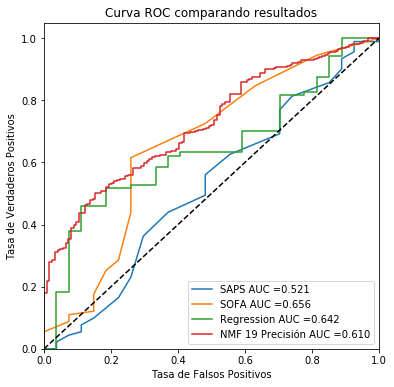

In [57]:
fig_size = [6, 6]
plt.rcParams["figure.figsize"] = fig_size
plt.figure()
roc_curveplot('SAPS',survived_test,saps,roc_auc_saps)
roc_curveplot('SOFA',survived_test,sofa,roc_auc_sofa)
roc_curveplot('Regression',surv_test,regresion,logisticReg['roc_auc'])
roc_curveplot(nmfresults[2]['name'],nmfresults[2]['survived_test'],nmfresults[2]['predict_poba'],nmfresults[2]['roc_auc'])
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC comparando resultados')
plt.legend(loc="lower right")
plt.show()

In [53]:
for nmfresult in nmfresults:
    print(nmfresult['name'])
    nmfresult['name'] = nmfresult['name'].replace("{'n_components': ",'').replace(", 'type':",'').replace("'",'').replace("}",'')


NMF 11 Menor error
NMF 5 Mejor Coeficiente de pearson
NMF 19 Precisión
NMF 56 AUC
